In [7]:
from gurobipy import Model, GRB, quicksum
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx  

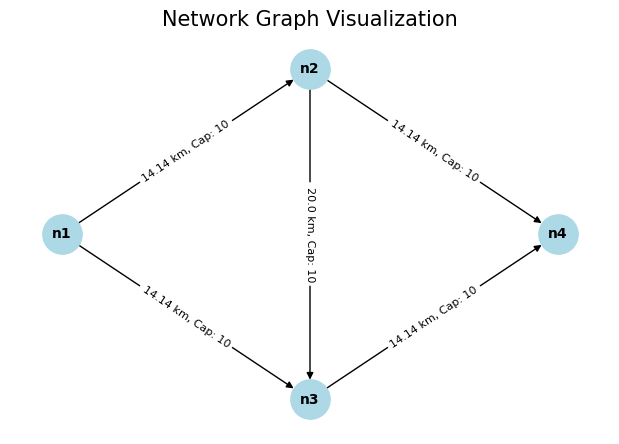

In [8]:
nodes = {
    "n1": (0, 0),
    "n2": (10, 10),
    "n3": (10, -10),
    "n4": (20, 0)
}

edges = {
    'e1': ['n1', 'n2'],
    'e2': ['n1', 'n3'],
    'e3': ['n2', 'n3'],
    'e4': ['n2', 'n4'],
    'e5': ['n3', 'n4']
}

arcs = [(edge[0], edge[1]) for edge in edges.values()]

def euclidean_distance(node1, node2):
    x1, y1 = nodes[node1]
    x2, y2 = nodes[node2]
    return round(((x2 - x1)**2 + (y2 - y1)**2)**0.5, 2)

arc_distance = {tuple(edge): euclidean_distance(edge[0], edge[1]) for edge in arcs}
arc_capacity = {tuple(edge): 10 for edge in arcs}  # 용량 임의 설정

demand = {
    'k1': {'origin': 'n1', 'destination': 'n4', 'amount': 18},
    'k2': {'origin': 'n2', 'destination': 'n3', 'amount': 5},
    'k3': {'origin': 'n1', 'destination': 'n3', 'amount': 7},  
    'k4': {'origin': 'n3', 'destination': 'n4', 'amount': 6}   
}

max_distance = {k: 30 for k in demand}  # 최대 허용 거리 설정
comps_st = {0: 1, 1: 0, 2: 0, 3: 1, 4: 1}  # 모든 엣지가 사용 가능 상태

G = nx.DiGraph()
for node, position in nodes.items():
    G.add_node(node, pos=position)
for (u, v) in arcs:
    distance = arc_distance[(u, v)]
    capacity = arc_capacity[(u, v)]
    G.add_edge(u, v, weight=distance, capacity=capacity)

plt.figure(figsize=(6, 4))
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_size=800, node_color="lightblue", font_size=10, font_weight="bold")
edge_labels = {edge: f"{arc_distance[edge]} km, Cap: {arc_capacity[edge]}" for edge in arcs}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)
plt.title("Network Graph Visualization", fontsize=15)
plt.show()

## **Unmet demand quantity**

In [9]:
# 수요 정의
demand = {
    'k1': {'origin': 'n1', 'destination': 'n4', 'amount': 18},
    'k2': {'origin': 'n2', 'destination': 'n3', 'amount': 5},
    'k3': {'origin': 'n1', 'destination': 'n3', 'amount': 7},  # 추가
    'k4': {'origin': 'n3', 'destination': 'n4', 'amount': 6}   # 추가
}


# Gurobi 모델 생성
model = Model("Network Flow Optimization")

# 변수 정의
flow = {}
for k, info in demand.items():
    for i, j in arcs:
        flow[k, i, j] = model.addVar(lb=0, ub=arc_capacity[(i, j)], vtype=GRB.CONTINUOUS, name=f"flow_{k}_{i}_{j}")

# 목적 함수: 미충족 수요 최소화
unmet_demand = {k: model.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"unsatisfied_{k}") for k in demand}
model.setObjective(quicksum(unmet_demand[k] for k in demand), GRB.MINIMIZE)

# 제약 조건 1: 흐름 보존
for k, info in demand.items():
    origin = info['origin']
    destination = info['destination']
    amount = info['amount']
    for node in nodes:
        inflow = quicksum(flow[k, i, j] for i, j in arcs if j == node)
        outflow = quicksum(flow[k, i, j] for i, j in arcs if i == node)
        if node == origin:
            model.addConstr(outflow - inflow == amount - unmet_demand[k], name=f"flow_conservation_{k}_{node}")
        elif node == destination:
            model.addConstr(outflow - inflow == -amount + unmet_demand[k], name=f"flow_conservation_{k}_{node}")
        else:
            model.addConstr(outflow - inflow == 0, name=f"flow_conservation_{k}_{node}")

# 제약 조건 2: 아크 용량 제한
for i, j in arcs:
    model.addConstr(quicksum(flow[k, i, j] for k in demand) <= arc_capacity[(i, j)], name=f"capacity_{i}_{j}")

# 제약 조건 3: 거리 제약
max_distance = {k: 30 for k in demand}  # 최대 허용 거리 설정
for k, info in demand.items():
    origin = info['origin']
    distance_expr = quicksum(arc_distance[(i, j)] * flow[k, i, j] for i, j in arcs)
    total_flow = quicksum(flow[k, i, j] for i, j in arcs if i == origin)
    model.addConstr(distance_expr <= max_distance[k] * total_flow, name=f"distance_{k}")

# 최적화
model.optimize()

# 결과 출력
if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found")
    for k, info in demand.items():
        print(f"Demand {k}: Unmet = {unmet_demand[k].X}")
        for i, j in arcs:
            if flow[k, i, j].X > 0:
                print(f"  Flow on {i} -> {j}: {flow[k, i, j].X}")
else:
    print("No Optimal Solution Found")


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 5 3600XT 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 25 rows, 24 columns and 88 nonzeros
Model fingerprint: 0x447ce3d1
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+01, 1e+01]
  RHS range        [5e+00, 2e+01]
Presolve removed 18 rows and 16 columns
Presolve time: 0.00s
Presolved: 7 rows, 8 columns, 22 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.600000e+01   0.000000e+00      0s
       5    5.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.000000000e+00
Optimal Solution Found
Demand k1: Unmet = 5.0
  Flow on n1 -> n2: 10.0
  Flow on n1 -> n3: 3.0
  Flow on n2 -> n4: 10.0


## **Unmet demand percentage**

In [10]:
# 수요 정의
demand = {
    'k1': {'origin': 'n1', 'destination': 'n4', 'amount': 18},
    'k2': {'origin': 'n2', 'destination': 'n3', 'amount': 5},
    'k3': {'origin': 'n1', 'destination': 'n3', 'amount': 7},  
    'k4': {'origin': 'n3', 'destination': 'n4', 'amount': 6}   
}


# Gurobi 모델 생성
model = Model("Network Flow Optimization")

# 변수 정의
flow = {}
unmet_demand = {}  # 미충족 수요 변수 정의
for k, info in demand.items():
    unmet_demand[k] = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"unsatisfied_{k}")
    for i, j in arcs:
        flow[k, i, j] = model.addVar(lb=0, ub=arc_capacity[(i, j)], vtype=GRB.CONTINUOUS, name=f"flow_{k}_{i}_{j}")

# 목적 함수: 총 수요량에 대한 미충족 수요 비율 최소화
total_demand = sum(info['amount'] for info in demand.values())  # 총 수요량
model.setObjective(
    (quicksum(unmet_demand[k] for k in demand) / total_demand) * 100, GRB.MINIMIZE
)

# 제약 조건 1: 흐름 보존
for k, info in demand.items():
    origin = info['origin']
    destination = info['destination']
    amount = info['amount']
    for node in nodes:
        inflow = quicksum(flow[k, i, j] for i, j in arcs if j == node)
        outflow = quicksum(flow[k, i, j] for i, j in arcs if i == node)
        if node == origin:
            model.addConstr(outflow - inflow == amount - unmet_demand[k], name=f"flow_conservation_{k}_{node}")
        elif node == destination:
            model.addConstr(outflow - inflow == -amount + unmet_demand[k], name=f"flow_conservation_{k}_{node}")
        else:
            model.addConstr(outflow - inflow == 0, name=f"flow_conservation_{k}_{node}")

# 제약 조건 2: 아크 용량 제한
for i, j in arcs:
    model.addConstr(quicksum(flow[k, i, j] for k in demand) <= arc_capacity[(i, j)], name=f"capacity_{i}_{j}")

# 제약 조건 3: 거리 제약
max_distance = {k: 30 for k in demand}  # 최대 허용 거리 설정
for k, info in demand.items():
    origin = info['origin']
    distance_expr = quicksum(arc_distance[(i, j)] * flow[k, i, j] for i, j in arcs)
    total_flow = quicksum(flow[k, i, j] for i, j in arcs if i == origin)
    model.addConstr(distance_expr <= max_distance[k] * total_flow, name=f"distance_{k}")

# 최적화
model.optimize()

# 결과 출력
if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found")
    # Optimal objective 출력 (미충족 수요 비율 합)
    print(f"Optimal Objective (Total Unmet Demand Percentage): {model.objVal:.2f}%")  # 과학적 표기법 대신 소수점 출력
    
    for k, info in demand.items():
        unmet = unmet_demand[k].X
        print(f"Demand {k}: Unmet = {unmet:.2f}")  # 미충족 수요량 소수점 형식으로 출력
        for i, j in arcs:
            flow_value = flow[k, i, j].X
            if flow_value > 0:
                print(f"  Flow on {i} -> {j}: {flow_value:.2f}")  # 흐름도 소수점 형식으로 출력
else:
    print("No Optimal Solution Found")


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 5 3600XT 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 25 rows, 24 columns and 88 nonzeros
Model fingerprint: 0x27fbb168
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e+00, 3e+00]
  Bounds range     [1e+01, 1e+01]
  RHS range        [5e+00, 2e+01]
Presolve removed 18 rows and 16 columns
Presolve time: 0.00s
Presolved: 7 rows, 8 columns, 22 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.600000e+01   0.000000e+00      0s
       5    1.3888889e+01   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.388888889e+01
Optimal Solution Found
Optimal Objective (Total Unmet Demand Percentage): 13.89%
Demand k1: Unmet = 5.00
  Flow on n1 ->

## **MCNF system function**

In [11]:
def multi_commodity_net_conn(comps_st, edges, arcs, arc_capacity, demand, arc_distance, max_distance):
    from gurobipy import Model, GRB, quicksum

    # Create Gurobi model
    model = Model("Network Flow Optimization")

    # Define variables
    flow = {}
    unmet_demand = {}
    for k, info in demand.items():
        unmet_demand[k] = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"unsatisfied_{k}")
        for i, j in arcs:
            # Determine capacity based on component state
            capacity = arc_capacity.get((i, j), 0) * comps_st[arcs.index((i, j))]
            flow[k, i, j] = model.addVar(lb=0, ub=capacity, vtype=GRB.CONTINUOUS, name=f"flow_{k}_{i}_{j}")

    # Objective function: Minimize the percentage of unmet demand relative to total demand
    total_demand = sum(info['amount'] for info in demand.values())
    model.setObjective(
        (quicksum(unmet_demand[k] for k in demand) / total_demand) * 100, GRB.MINIMIZE
    )
    
    # Extract all nodes from edge values
    nodes = set(node for edge in edges.values() for node in edge)

    # Constraint 1: Flow conservation
    for k, info in demand.items():
        origin = info['origin']
        destination = info['destination']
        amount = info['amount']
        for node in nodes: 
            inflow = quicksum(flow[k, i, j] for i, j in arcs if j == node)
            outflow = quicksum(flow[k, i, j] for i, j in arcs if i == node)
            if node == origin:
                model.addConstr(outflow - inflow == amount - unmet_demand[k])
            elif node == destination:
                model.addConstr(outflow - inflow == -amount + unmet_demand[k])
            else:
                model.addConstr(outflow - inflow == 0)

    # Constraint 2: Arc capacity limits
    for i, j in arcs:
        model.addConstr(quicksum(flow[k, i, j] for k in demand) <= arc_capacity.get((i, j), 0))

    # Constraint 3: Distance limits
    for k, info in demand.items():
        origin = info['origin']
        distance_expr = quicksum(arc_distance.get((i, j), 0) * flow[k, i, j] for i, j in arcs)
        total_flow = quicksum(flow[k, i, j] for i, j in arcs if i == origin)
        model.addConstr(distance_expr <= max_distance[k] * total_flow)

    # Perform optimization
    model.optimize()

    # Process results
    if model.status == GRB.OPTIMAL:
        unmet_demand_percentage = model.objVal 
        flows = {
            k: {arc: flow[k, arc[0], arc[1]].X for arc in arcs} for k in demand
        }
        return unmet_demand_percentage, flows
    else:
        return None, None


In [12]:
unmet_percentage, flows = multi_commodity_net_conn(
    comps_st=comps_st,
    edges=edges,
    arcs=arcs,
    arc_capacity=arc_capacity,
    demand=demand,
    arc_distance=arc_distance,
    max_distance=max_distance
)

if unmet_percentage is not None:
    print(f"Unmet Demand Percentage: {unmet_percentage:.2f}%")
    print("Flow Allocation:")
    for k, flow_dict in flows.items():
        print(f"  Commodity {k}:")
        for arc, flow_value in flow_dict.items():
            if flow_value > 0:
                print(f"    Flow on {arc}: {flow_value:.2f}")
else:
    print("Optimization failed or infeasible.")

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 5 3600XT 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 25 rows, 24 columns and 88 nonzeros
Model fingerprint: 0x7bdeb3ca
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e+00, 3e+00]
  Bounds range     [1e+01, 1e+01]
  RHS range        [5e+00, 2e+01]
Presolve removed 25 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5555556e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  5.555555556e+01
Unmet Demand Percentage: 55.56%
Flow Allocation:
  Commodity k1:
    Flow on ('n1', 'n2'): 10.00
    Flow on ('n2', 'n4'): 10.00
  Commodity k2:
  Commodity k3:
  Commodity k4:
    Flow on